## 0. Background

Zillow is the largest digital inventory and estimation of American homes in the world. From the Zillow website, the Zestimate home valuation model is Zillow's estimate of a home's market value which incorporates public and user-submitted data, taking into account home faces, location and market conditions.

## 1. Introduction

This project is to construct a model to predict a home's current market value, and it is a Regression problem.


## 2. Import package

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

## 3. Read the data

In [14]:
train = pd.read_csv('train_2016_v2.csv')
properties = pd.read_csv('properties_2016.csv')
sample = pd.read_csv('sample_submission.csv')
#data_17 = pd.read_csv('train_2017.csv')
#properties_17 = pd.read_csv('properties_2017.csv')

In [11]:
print('Training Size:' + str(train.shape))
print('Property Size:' + str(properties.shape))
#print('Sample Size:' + str(test.shape))

Training Size:(90275, 3)
Property Size:(2985217, 58)


In [4]:
#Convert the dataset
for c, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:
        properties[c] = properties[c].astype(np.float32)
    if dtype == np.int64:
        properties[c] = properties[c].astype(np.int32)

In [12]:
#for c in test.columns:
    #if test[c].dtype == int:
        #test[c] = test[c].astype(np.int32)
    #if test[c].dtype == float:
        #test[c] = test[c].astype(np.float32)

In [7]:
for c in train.columns:
    if train[c].dtype == int:
        train[c] = train[c].astype(np.int32)
    if train[c].dtype == float:
        train[c] = train[c].astype(np.float32)

## 4. Overview of datasets

In [15]:
train.head(3)

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01


In [13]:
properties.head(3)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.369141,NaN,NaN,NaN


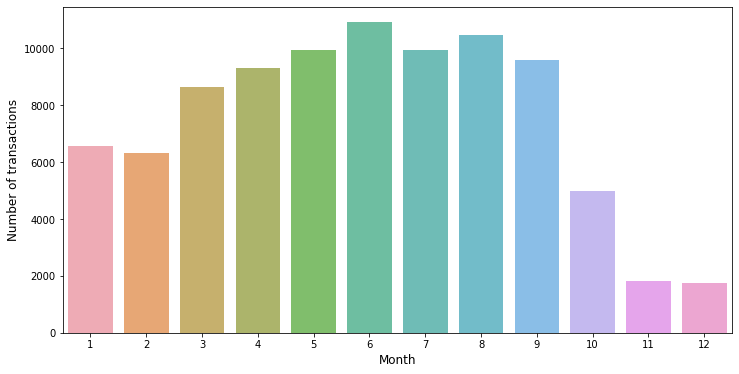

In [16]:
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
trans_month = train['transactiondate'].dt.month.value_counts()
plt.figure(figsize=(12,6))
sns.barplot(trans_month.index, trans_month.values, alpha = 0.8)
plt.xlabel('Month',fontsize = 12)
plt.ylabel('Number of transactions',fontsize = 12)
plt.show()

In [18]:
#data['Month'] = data['transactiondate'].dt.month
#train_month_16 = data_16[data_16['Month']<10]
#test_month_16 = data_16[data_16['Month']>=10]

In [19]:
properties.count()

parcelid                        2985217
airconditioningtypeid            811519
architecturalstyletypeid           6061
basementsqft                       1628
bathroomcnt                     2973755
bedroomcnt                      2973767
buildingclasstypeid               12629
buildingqualitytypeid           1938488
calculatedbathnbr               2856305
decktypeid                        17096
finishedfloor1squarefeet         202717
calculatedfinishedsquarefeet    2929652
finishedsquarefeet12            2709184
finishedsquarefeet13               7672
finishedsquarefeet15             190798
finishedsquarefeet50             202717
finishedsquarefeet6               22001
fips                            2973780
fireplacecnt                     312637
fullbathcnt                     2856305
garagecarcnt                     883267
garagetotalsqft                  883267
hashottuborspa                    69014
heatingorsystemtypeid           1806401
latitude                        2973780


## 5. Remove outliers

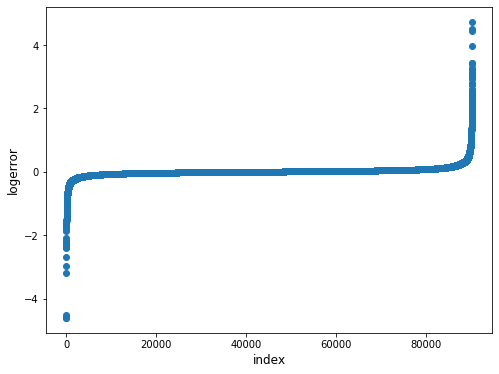

In [22]:
#Check target variable logerror
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]),np.sort(train.logerror.values))
plt.xlabel('index',fontsize = 12)
plt.ylabel('logerror',fontsize = 12)
plt.show()

The results are quite good,except some outliers. Let us check these outliers.

In [23]:
#exclude 0.5% of the data as outliers (see from the charts)
train = train[train.logerror < train.logerror.quantile(0.9975)]
train = train[train.logerror > train.logerror.quantile(0.0025)]

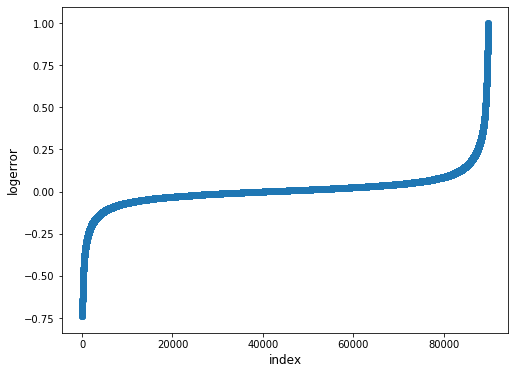

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]),np.sort(train.logerror.values))
plt.xlabel('index',fontsize = 12)
plt.ylabel('logerror',fontsize = 12)
plt.show()

## 6. Log-transform the target

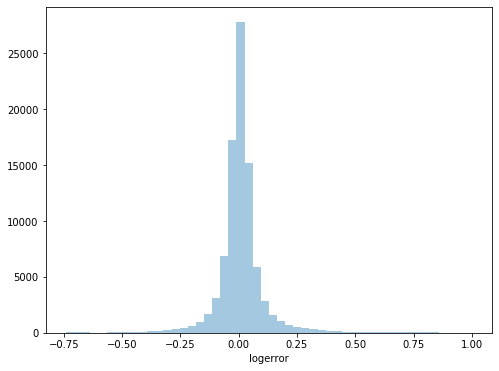

In [25]:
plt.figure(figsize = (8,6))
sns.distplot(train.logerror,bins = 50,kde = False)
plt.xlabel('logerror')
plt.show()

Logerror looks like normal distribution. (重要问题 : Why normality is important）

## 7. Missing data imputation

A lot of null values here. Let's take a look at them.

In [27]:
miss_per = properties.isnull().sum(axis = 1)/properties.shape[1]
miss_per[miss_per>0.8].count() #bathroomcnt&bedroomcnt are all 0,but we have location info,maybe keep?

11439

In [28]:
miss_per[miss_per>=0.98].count() #Only have parcelid so we can safely drop

11437

In [29]:
df_proper = properties[miss_per<0.98]
df_proper.shape

(2973780, 58)

In [30]:
col_miss = properties.isnull().sum(axis = 0)/properties.shape[0]
col_miss[col_miss>0.98]

architecturalstyletypeid    0.997970
basementsqft                0.999455
buildingclasstypeid         0.995769
decktypeid                  0.994273
finishedsquarefeet13        0.997430
finishedsquarefeet6         0.992630
poolsizesum                 0.990634
pooltypeid10                0.987626
pooltypeid2                 0.989255
storytypeid                 0.999456
typeconstructiontypeid      0.997740
yardbuildingsqft26          0.999113
fireplaceflag               0.998270
taxdelinquencyflag          0.981086
taxdelinquencyyear          0.981085
dtype: float64

### Take a look at the features with a lot of na

### 7.1 Merge dataset

In [390]:
df_16 = pd.merge(data_16,properties_16,on = 'parcelid',how = 'left',indicator = True) #properties中很多parcelid没有merge进来

In [391]:
col_miss = df_16.isnull().sum(axis = 0)/df_16.shape[0]
col_miss[col_miss>0.98]

architecturalstyletypeid    0.997109
basementsqft                0.999524
buildingclasstypeid         0.999823
decktypeid                  0.992711
finishedsquarefeet13        0.999634
finishedsquarefeet6         0.995336
poolsizesum                 0.989266
pooltypeid10                0.987139
pooltypeid2                 0.986663
storytypeid                 0.999524
typeconstructiontypeid      0.996688
yardbuildingsqft26          0.998948
fireplaceflag               0.997541
taxdelinquencyflag          0.980249
taxdelinquencyyear          0.980249
dtype: float64

In [104]:
#architecturalstyletypeid: Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
#This one is categorical 
df_16['architecturalstyletypeid'][df_16['architecturalstyletypeid'].notnull()].value_counts()

7.0     221
8.0      16
2.0      11
21.0      8
3.0       4
10.0      1
Name: architecturalstyletypeid, dtype: int64

In [106]:
#basementsqft：Finished living area below or partially below ground level
#Na should be 0?
df_16['basementsqft'][df_16['basementsqft'].notnull()].value_counts()

1528.0    3
1312.0    2
700.0     2
1210.0    1
540.0     1
184.0     1
676.0     1
198.0     1
564.0     1
690.0     1
831.0     1
1048.0    1
557.0     1
771.0     1
1555.0    1
671.0     1
168.0     1
330.0     1
260.0     1
312.0     1
608.0     1
760.0     1
100.0     1
579.0     1
510.0     1
234.0     1
585.0     1
196.0     1
515.0     1
493.0     1
913.0     1
238.0     1
485.0     1
1551.0    1
616.0     1
162.0     1
802.0     1
1350.0    1
814.0     1
Name: basementsqft, dtype: int64

In [107]:
#buildingclasstypeid:The building framing type (steel frame, wood frame, concrete/brick) 
#This one is categorical, Na is just Na?
df_16['buildingclasstypeid'][df_16['buildingclasstypeid'].notnull()].value_counts()

4.0    16
Name: buildingclasstypeid, dtype: int64

In [108]:
#decktypeid:Type of deck (if any) present on parcel
#categorical..does this matter?
#I think we can safely drop this feature
properties_16['decktypeid'][properties_16['decktypeid'].notnull()].value_counts()

66.0    17096
Name: decktypeid, dtype: int64

In [109]:
#finishedsquarefeet13:Perimeter  living area
#Fill in with mean value is better
df_16['finishedsquarefeet13'][df_16['finishedsquarefeet13'].notnull()].value_counts()

1440.0    17
1248.0     3
1344.0     3
1536.0     2
1392.0     2
1056.0     1
1416.0     1
1584.0     1
1152.0     1
1464.0     1
1566.0     1
Name: finishedsquarefeet13, dtype: int64

In [110]:
#finishedsquarefeet6：Base unfinished and finished area
# What does this mean??
df_16['finishedsquarefeet6'][df_16['finishedsquarefeet6'].notnull()].value_counts()

720.0     5
4442.0    4
2180.0    3
480.0     3
3470.0    3
2530.0    3
3500.0    3
572.0     3
4345.0    3
1794.0    2
2172.0    2
1904.0    2
899.0     2
824.0     2
1248.0    2
800.0     2
1670.0    2
924.0     2
2628.0    2
2647.0    2
765.0     2
1658.0    2
3240.0    2
1650.0    2
1750.0    2
1629.0    2
2388.0    2
1446.0    2
4379.0    2
3431.0    2
         ..
2277.0    1
1471.0    1
4452.0    1
4446.0    1
1843.0    1
5229.0    1
7224.0    1
726.0     1
531.0     1
3432.0    1
3554.0    1
1878.0    1
1556.0    1
2428.0    1
1228.0    1
6338.0    1
3388.0    1
2075.0    1
2430.0    1
882.0     1
3164.0    1
1820.0    1
1044.0    1
3912.0    1
1346.0    1
1492.0    1
4699.0    1
731.0     1
1006.0    1
605.0     1
Name: finishedsquarefeet6, Length: 360, dtype: int64

In [111]:
#poolsizesum： Total square footage of all pools on property
#Fill in with mean value
df_16['poolsizesum'][df_16['poolsizesum'].notnull()].value_counts()

450.0     105
400.0      41
800.0      39
500.0      36
600.0      35
512.0      30
480.0      27
648.0      18
420.0      17
525.0      15
720.0      13
640.0      12
544.0      11
448.0      11
540.0      11
360.0      11
680.0      10
700.0       9
576.0       8
560.0       8
380.0       8
510.0       8
750.0       8
405.0       8
608.0       7
684.0       7
350.0       7
570.0       7
384.0       7
300.0       7
         ... 
343.0       1
795.0       1
714.0       1
291.0       1
513.0       1
451.0       1
367.0       1
642.0       1
546.0       1
908.0       1
442.0       1
429.0       1
294.0       1
1020.0      1
426.0       1
1052.0      1
851.0       1
948.0       1
623.0       1
503.0       1
971.0       1
1125.0      1
815.0       1
647.0       1
537.0       1
893.0       1
727.0       1
649.0       1
357.0       1
690.0       1
Name: poolsizesum, Length: 273, dtype: int64

In [112]:
#pooltypeid10: Spa or Hot Tub
#The na should be 0
df_16['pooltypeid10'][df_16['pooltypeid10'].notnull()].value_counts()

1.0    1161
Name: pooltypeid10, dtype: int64

In [113]:
# pooltypeid2: Pool with Spa/Hot Tub
# The na should be 0?
df_16['pooltypeid2'][df_16['pooltypeid2'].notnull()].value_counts()

1.0    1204
Name: pooltypeid2, dtype: int64

In [114]:
#storytypeid：Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.)
#I don't know how to deal with the na
df_16['storytypeid'][df_16['storytypeid'].notnull()].value_counts()

7.0    43
Name: storytypeid, dtype: int64

In [115]:
#typeconstructiontypeid： What type of construction material was used to construct the home
#categorical
df_16['typeconstructiontypeid'][df_16['typeconstructiontypeid'].notnull()].value_counts()

6.0     296
4.0       2
13.0      1
Name: typeconstructiontypeid, dtype: int64

In [116]:
#yardbuildingsqft26:Storage shed/building in yard
#
df_16['yardbuildingsqft26'][df_16['yardbuildingsqft26'].notnull()].value_counts()

120.0     6
125.0     3
144.0     3
180.0     3
60.0      3
37.0      2
108.0     2
204.0     2
168.0     2
56.0      2
100.0     2
88.0      2
400.0     2
1200.0    2
310.0     1
1197.0    1
231.0     1
230.0     1
268.0     1
150.0     1
477.0     1
252.0     1
119.0     1
90.0      1
264.0     1
48.0      1
110.0     1
36.0      1
54.0      1
33.0      1
         ..
34.0      1
504.0     1
276.0     1
72.0      1
96.0      1
133.0     1
408.0     1
525.0     1
49.0      1
160.0     1
288.0     1
480.0     1
192.0     1
943.0     1
290.0     1
41.0      1
136.0     1
1182.0    1
1000.0    1
960.0     1
627.0     1
642.0     1
78.0      1
648.0     1
1366.0    1
159.0     1
104.0     1
846.0     1
864.0     1
550.0     1
Name: yardbuildingsqft26, Length: 73, dtype: int64

In [117]:
#fireplaceflag: Is a fireplace present in this home 
#
df_16['fireplaceflag'][df_16['fireplaceflag'].notnull()].value_counts()

True    222
Name: fireplaceflag, dtype: int64

In [118]:
#taxdelinquencyflag:Property taxes for this parcel are past due as of 2015
#
df_16['taxdelinquencyflag'][df_16['taxdelinquencyflag'].notnull()].value_counts()

Y    1783
Name: taxdelinquencyflag, dtype: int64

In [119]:
#taxdelinquencyyear:Year for which the unpaid propert taxes were due 
df_16['taxdelinquencyyear'][df_16['taxdelinquencyyear'].notnull()].value_counts()

14.0    628
15.0    518
13.0    210
12.0    154
10.0     89
11.0     85
9.0      63
8.0      24
7.0       8
6.0       3
99.0      1
Name: taxdelinquencyyear, dtype: int64

In [392]:
#drop columns where missing percentage larger than 98%
miss_col = col_miss[col_miss>0.98]
drop_col = []
for i in miss_col.index:
    drop_col.append(i)
df_16.drop(columns = drop_col,inplace = True)

In [393]:
df_16.shape

(90275, 47)

In [394]:
df_16.columns

Index(['parcelid', 'logerror', 'transactiondate', 'Month',
       'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt',
       'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yearbuilt',
       'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount',
       'censustractandblock', '_merge'],
      d

In [395]:
columns = df_16.isnull().sum(axis=0)
columns[columns>0]

airconditioningtypeid           61494
buildingqualitytypeid           32911
calculatedbathnbr                1182
finishedfloor1squarefeet        83419
calculatedfinishedsquarefeet      661
finishedsquarefeet12             4679
finishedsquarefeet15            86711
finishedsquarefeet50            83419
fireplacecnt                    80668
fullbathcnt                      1182
garagecarcnt                    60338
garagetotalsqft                 60338
hashottuborspa                  87910
heatingorsystemtypeid           34195
lotsizesquarefeet               10150
poolcnt                         72374
pooltypeid7                     73578
propertycountylandusecode           1
propertyzoningdesc              31962
regionidcity                     1803
regionidneighborhood            54263
regionidzip                        35
threequarterbathnbr             78266
unitcnt                         31922
yardbuildingsqft17              87629
yearbuilt                         756
numberofstor

In [396]:
columns[columns>0].index

Index(['airconditioningtypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'hashottuborspa', 'heatingorsystemtypeid', 'lotsizesquarefeet',
       'poolcnt', 'pooltypeid7', 'propertycountylandusecode',
       'propertyzoningdesc', 'regionidcity', 'regionidneighborhood',
       'regionidzip', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount',
       'censustractandblock'],
      dtype='object')

### 7.2 Deal with null values

In [397]:
#Deal with null values
zero_list = ['airconditioningtypeid','fireplacecnt','poolcnt','garagecarcnt','garagetotalsqft','pooltypeid7',
            'yardbuildingsqft17',]
mode_list = ['buildingqualitytypeid','calculatedbathnbr','fullbathcnt','hashottuborspa','threequarterbathnbr',
            'heatingorsystemtypeid','propertycountylandusecode','unitcnt','yearbuilt','numberofstories',
            'structuretaxvaluedollarcnt','regionidzip']
mean_list = ['finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12',
            'finishedsquarefeet15', 'finishedsquarefeet50','lotsizesquarefeet','taxamount','taxvaluedollarcnt','landtaxvaluedollarcnt']
df_16[zero_list] = df_16[zero_list].fillna(0)
df_16[mode_list] = df_16[mode_list].fillna(df_16[mode_list].mode().iloc[0])
df_16[mean_list] = df_16[mean_list].fillna(df_16[mean_list].mean())

In [398]:
df_16_new = df_16.drop(columns = '_merge')

In [399]:
df_16_new.dtypes.value_counts()

float64           40
object             2
int64              2
datetime64[ns]     1
bool               1
dtype: int64

## 8. Feature Engineering

### 8.1 Univariate Analysis

In [400]:
#get the correlation between numerical variables and logerror
x_col = [col for col in df_16_new.columns if col not in ['logerror'] if df_16_new[col].dtypes == 'float64']

label = []
corrcoef = []
for col in x_col:
    label.append(col)
    corrcoef.append(np.corrcoef(df_16_new[col].values,df_16_new['logerror'].values)[0,1])

corr = pd.DataFrame({'cols':label,'corr_coef':corrcoef})
corr_df = corr.sort_values(by = 'corr_coef')

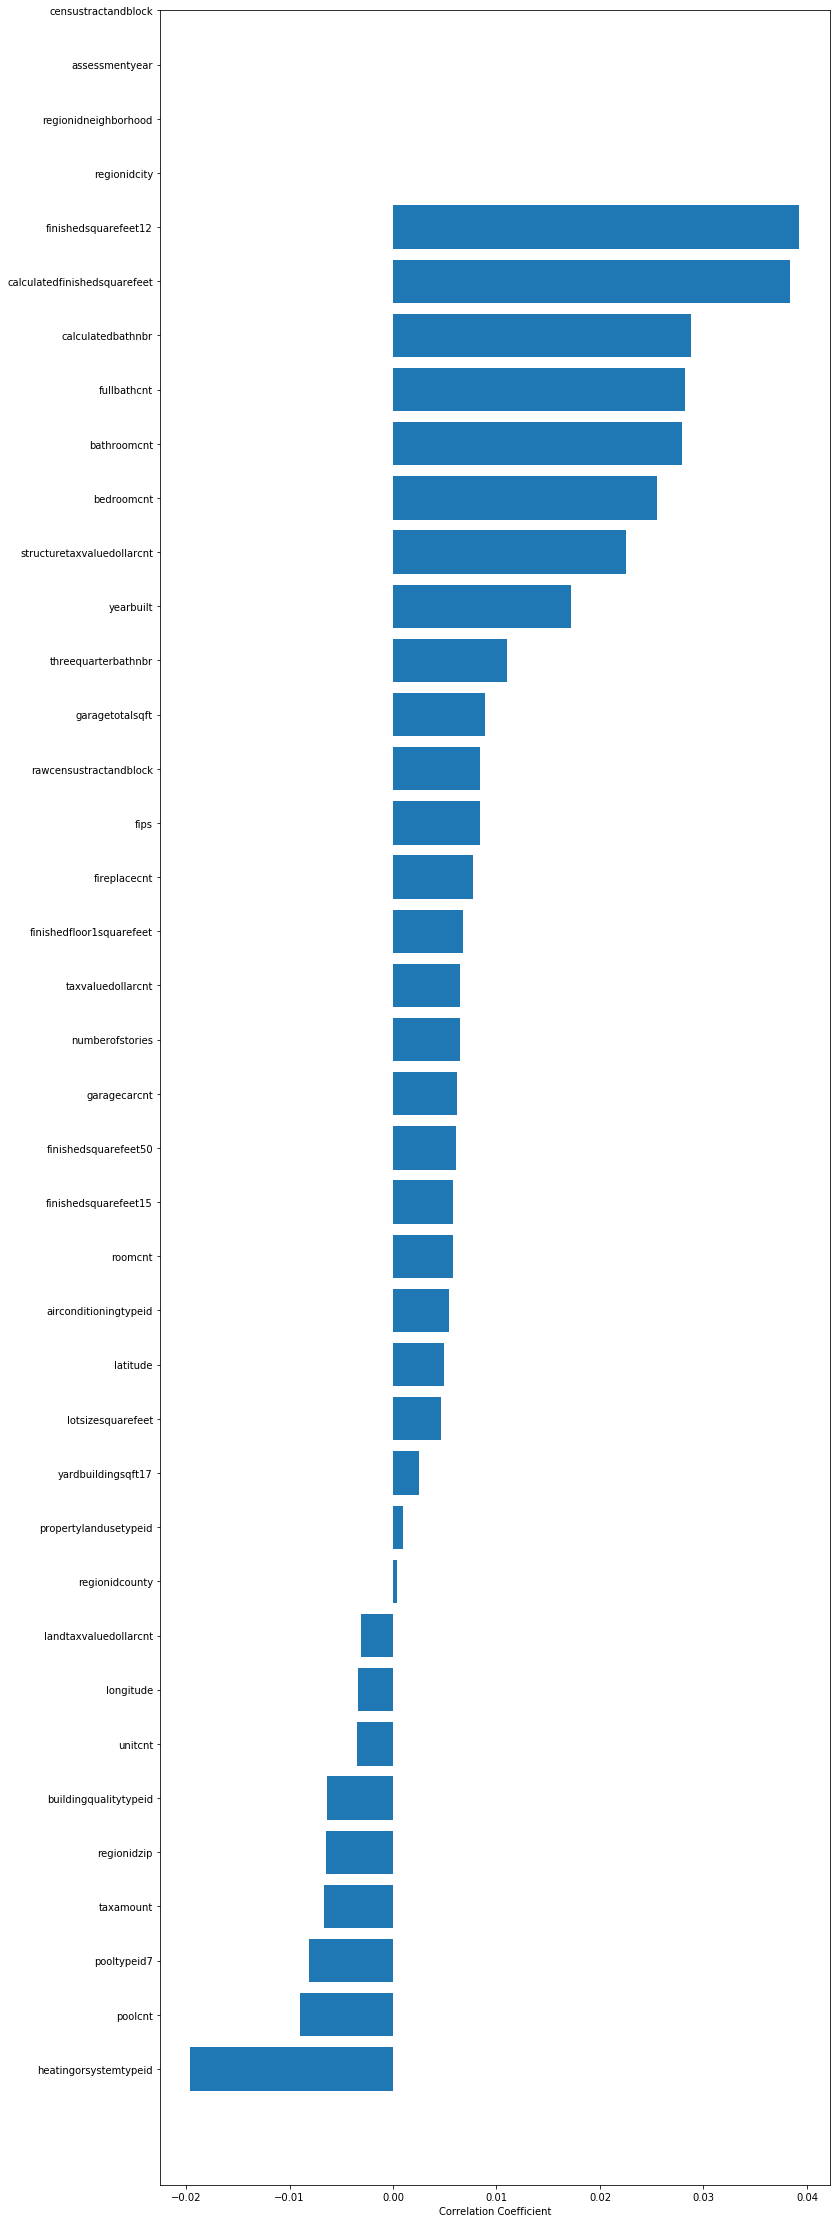

In [401]:
#visduallize our corrcoef
fig,ax = plt.subplots(figsize = (12,40))
ind = np.arange(len(label))
width = 0.9
ax.barh(ind,np.array(corr_df['corr_coef'].values))
ax.set_xlabel('Correlation Coefficient')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.cols.values)
plt.show()

From the chart we can see most of the variables are not highly correlated to logerror. Let's look at the variables with relatively higher correlation coefficients.

In [402]:
high_corr = corr_df[(corr_df.corr_coef > 0.02)|(corr_df.corr_coef <-0.005)]
high_corr

,cols,corr_coef
15,heatingorsystemtypeid,-0.019586
19,poolcnt,-0.008983
20,pooltypeid7,-0.008078
37,taxamount,-0.006671
26,regionidzip,-0.006487
3,buildingqualitytypeid,-0.006406
33,structuretaxvaluedollarcnt,0.022481
2,bedroomcnt,0.025467
1,bathroomcnt,0.027889
12,fullbathcnt,0.028197


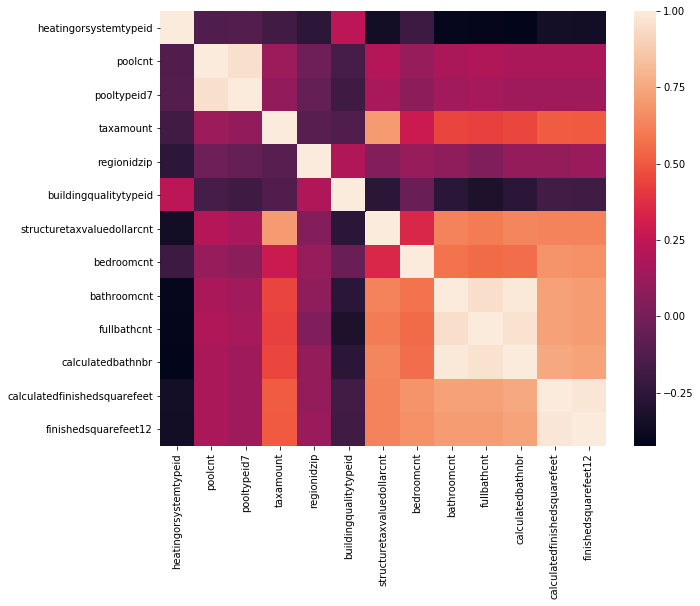

In [403]:
#Use heatmap to see the correlation between these variables
col_label = high_corr.cols.tolist()
values = df_16_new[col_label]
colormap = values.corr(method='spearman')
fig,ax = plt.subplots(figsize = (10,8))
sns.heatmap(colormap)
plt.show()

We can find that some numerical variables are highly correlated. Let's go through some 'impoetant features' one by one.\
Features: heatingorsystemtypeid, taxamount, poolcnt, finishedsquarefeet12, bathroomcnt, bedroomcnt, structuretaxvaluedollarcnt, buildingqualitytypeid	

In [404]:
features = ['heatingorsystemtypeid','taxamount','poolcnt','finishedsquarefeet12', 'bathroomcnt', 'bedroomcnt', 
            'structuretaxvaluedollarcnt', 'buildingqualitytypeid','Month']
train_16 = df_16_new[features]
train_16.head()

,heatingorsystemtypeid,taxamount,poolcnt,finishedsquarefeet12,bathroomcnt,bedroomcnt,structuretaxvaluedollarcnt,buildingqualitytypeid,Month
0,2.0,6735.88,0.0,1684.0,2.0,3.0,122754.0,4.0,1
1,2.0,10153.02,0.0,2263.0,3.5,4.0,346458.0,7.0,1
2,2.0,11484.48,0.0,2217.0,3.0,2.0,61994.0,4.0,1
3,2.0,3048.74,0.0,839.0,2.0,2.0,171518.0,4.0,1
4,2.0,5488.96,1.0,2283.0,2.5,4.0,169574.0,7.0,1


In [405]:
#Process categorical variables
le = preprocessing.LabelEncoder()
le.fit(train_16['heatingorsystemtypeid'])
train_16['heatingorsystemtypeid'] = le.transform(train_16['heatingorsystemtypeid'])
le2 = preprocessing.LabelEncoder()
le2.fit(train_16['buildingqualitytypeid'])
train_16['buildingqualitytypeid'] = le2.transform(train_16['buildingqualitytypeid'])

In [406]:
train_16.head()

,heatingorsystemtypeid,taxamount,poolcnt,finishedsquarefeet12,bathroomcnt,bedroomcnt,structuretaxvaluedollarcnt,buildingqualitytypeid,Month
0,1,6735.88,0.0,1684.0,2.0,3.0,122754.0,1,1
1,1,10153.02,0.0,2263.0,3.5,4.0,346458.0,3,1
2,1,11484.48,0.0,2217.0,3.0,2.0,61994.0,1,1
3,1,3048.74,0.0,839.0,2.0,2.0,171518.0,1,1
4,1,5488.96,1.0,2283.0,2.5,4.0,169574.0,3,1


### 8.2 Create New Features

In [407]:
#Use kmeans to cluster latitude and longitude
print('Number of unqiue latitude:',df_16_new.latitude.unique().shape[0])
print('Number of unqiue longitude:',df_16_new.latitude.unique().shape[0])

Number of unqiue latitude: 73312
Number of unqiue longitude: 73312


In [408]:
Clf_x = df_16_new.loc[:,['latitude','longitude']]
num_center = 10
kmeans = KMeans(n_clusters=center, random_state=0).fit(Clf_x)
id_label=kmeans.labels_

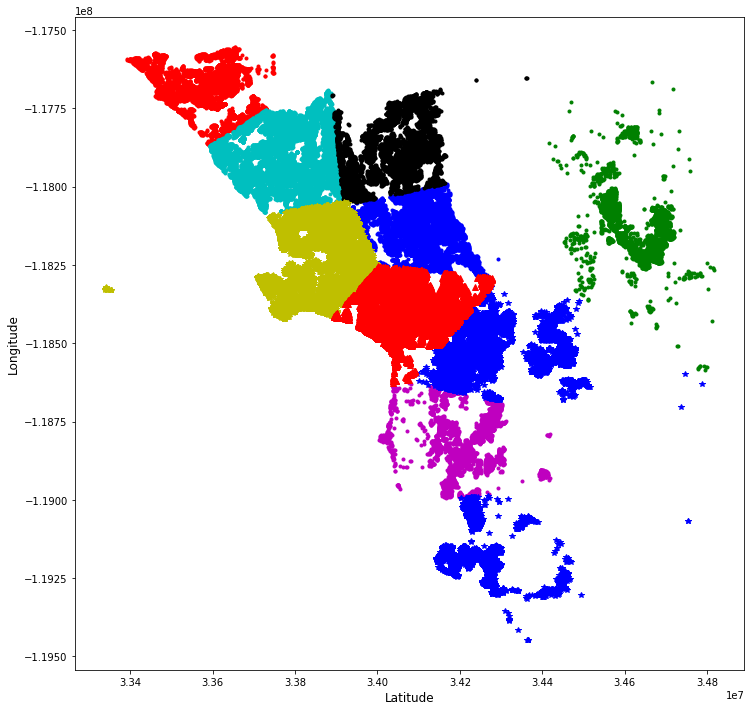

In [409]:
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','y*','b*','r^'])
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(num_center):
    cluster=np.where(id_label==i)[0]
    plt.plot(Clf_x.latitude[cluster].values,Clf_x.longitude[cluster].values,ptsymb[i])
plt.show()

In [410]:
cls = {}
df_16_new['location'] = 0
for i in range(num_center):
    cls[i] = np.where(id_label==i)[0].tolist()
    df_16_new['location'].iloc[cls[i]] = i

In [411]:
train_16['location'] = df_16_new['location']
le3 = preprocessing.LabelEncoder()
le3.fit(train_16['location'])
train_16['location'] = le3.transform(train_16['location'])

## 9. Feature Selection

## 10. Predictive Modeling

### 10.1 Train test split

In [413]:
train_month_16 = train_16.head()

,heatingorsystemtypeid,taxamount,poolcnt,finishedsquarefeet12,bathroomcnt,bedroomcnt,structuretaxvaluedollarcnt,buildingqualitytypeid,Month,location
0,1,6735.88,0.0,1684.0,2.0,3.0,122754.0,1,1,6
1,1,10153.02,0.0,2263.0,3.5,4.0,346458.0,3,1,1
2,1,11484.48,0.0,2217.0,3.0,2.0,61994.0,1,1,0
3,1,3048.74,0.0,839.0,2.0,2.0,171518.0,1,1,7
4,1,5488.96,1.0,2283.0,2.5,4.0,169574.0,3,1,1


In [354]:
X = train_16.values
y = data_16['logerror'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [355]:
X_train.shape

(72220, 9)

### 10.2 Normalize data

In [356]:
X_scaled_train = (X_train - X_train.mean(axis = 0))/X_train.std(axis = 0)
X_scaled_test = (X_test - X_test.mean(axis = 0))/X_test.std(axis = 0)

In [377]:
#Linear Regression
lm = LinearRegression().fit(X_scaled_train,y_train)
y_predict = lm.predict(X_scaled_test)
mean_squared_error(y_predict,y_test)

0.0259598238631482

In [360]:
#Random Forst
RF = RandomForestRegressor(max_depth=2, random_state=0)
RF.fit(X_scaled_train, y_train)
y_predict_rf = RF.predict(X_scaled_test)

In [378]:
mean_squared_error(y_predict_rf,y_test)

0.025971154350326705

In [420]:
#CatBoost
!pip install catboost

     |████████████████████████████████| 10.6MB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 7.3MB 20.5MB/s eta 0:00:01     |█████████▊                      | 2.2MB 20.5MB/s eta 0:00:01
  Stored in directory: /Users/chenzhangqi/Library/Caches/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [422]:
from catboost import CatBoostRegressor
model_cat =CatBoostRegressor(iterations = 1000,learning_rate = 0.01, depth=2, loss_function = 'MAE', 
                             eval_metric = 'MAE', random_seed = 2)
model_cat.fit(X_scaled_train, y_train,)

0:	learn: 0.0680758	total: 70.8ms	remaining: 1m 10s
1:	learn: 0.0680730	total: 83.4ms	remaining: 41.6s
2:	learn: 0.0680700	total: 95.7ms	remaining: 31.8s
3:	learn: 0.0680674	total: 107ms	remaining: 26.7s
4:	learn: 0.0680646	total: 118ms	remaining: 23.5s
5:	learn: 0.0680617	total: 130ms	remaining: 21.5s
6:	learn: 0.0680592	total: 142ms	remaining: 20.1s
7:	learn: 0.0680566	total: 155ms	remaining: 19.3s
8:	learn: 0.0680541	total: 168ms	remaining: 18.5s
9:	learn: 0.0680512	total: 179ms	remaining: 17.8s
10:	learn: 0.0680485	total: 191ms	remaining: 17.2s
11:	learn: 0.0680460	total: 203ms	remaining: 16.7s
12:	learn: 0.0680430	total: 214ms	remaining: 16.3s
13:	learn: 0.0680402	total: 226ms	remaining: 15.9s
14:	learn: 0.0680375	total: 239ms	remaining: 15.7s
15:	learn: 0.0680350	total: 252ms	remaining: 15.5s
16:	learn: 0.0680326	total: 265ms	remaining: 15.3s
17:	learn: 0.0680298	total: 281ms	remaining: 15.3s
18:	learn: 0.0680276	total: 303ms	remaining: 15.7s
19:	learn: 0.0680253	total: 319ms	rem

172:	learn: 0.0678419	total: 3.51s	remaining: 16.8s
173:	learn: 0.0678415	total: 3.53s	remaining: 16.7s
174:	learn: 0.0678408	total: 3.56s	remaining: 16.8s
175:	learn: 0.0678401	total: 3.58s	remaining: 16.8s
176:	learn: 0.0678394	total: 3.6s	remaining: 16.8s
177:	learn: 0.0678389	total: 3.64s	remaining: 16.8s
178:	learn: 0.0678384	total: 3.67s	remaining: 16.8s
179:	learn: 0.0678378	total: 3.7s	remaining: 16.9s
180:	learn: 0.0678373	total: 3.73s	remaining: 16.9s
181:	learn: 0.0678365	total: 3.75s	remaining: 16.8s
182:	learn: 0.0678360	total: 3.77s	remaining: 16.8s
183:	learn: 0.0678356	total: 3.79s	remaining: 16.8s
184:	learn: 0.0678350	total: 3.81s	remaining: 16.8s
185:	learn: 0.0678344	total: 3.84s	remaining: 16.8s
186:	learn: 0.0678339	total: 3.86s	remaining: 16.8s
187:	learn: 0.0678333	total: 3.87s	remaining: 16.7s
188:	learn: 0.0678328	total: 3.88s	remaining: 16.7s
189:	learn: 0.0678321	total: 3.9s	remaining: 16.6s
190:	learn: 0.0678318	total: 3.91s	remaining: 16.6s
191:	learn: 0.0

344:	learn: 0.0677731	total: 7.03s	remaining: 13.4s
345:	learn: 0.0677728	total: 7.05s	remaining: 13.3s
346:	learn: 0.0677726	total: 7.07s	remaining: 13.3s
347:	learn: 0.0677724	total: 7.08s	remaining: 13.3s
348:	learn: 0.0677721	total: 7.09s	remaining: 13.2s
349:	learn: 0.0677718	total: 7.1s	remaining: 13.2s
350:	learn: 0.0677716	total: 7.12s	remaining: 13.2s
351:	learn: 0.0677713	total: 7.13s	remaining: 13.1s
352:	learn: 0.0677711	total: 7.14s	remaining: 13.1s
353:	learn: 0.0677709	total: 7.15s	remaining: 13s
354:	learn: 0.0677705	total: 7.16s	remaining: 13s
355:	learn: 0.0677701	total: 7.17s	remaining: 13s
356:	learn: 0.0677698	total: 7.18s	remaining: 12.9s
357:	learn: 0.0677695	total: 7.19s	remaining: 12.9s
358:	learn: 0.0677690	total: 7.21s	remaining: 12.9s
359:	learn: 0.0677687	total: 7.22s	remaining: 12.8s
360:	learn: 0.0677685	total: 7.23s	remaining: 12.8s
361:	learn: 0.0677681	total: 7.25s	remaining: 12.8s
362:	learn: 0.0677678	total: 7.26s	remaining: 12.7s
363:	learn: 0.06776

504:	learn: 0.0677328	total: 9.11s	remaining: 8.93s
505:	learn: 0.0677324	total: 9.13s	remaining: 8.91s
506:	learn: 0.0677322	total: 9.14s	remaining: 8.89s
507:	learn: 0.0677320	total: 9.15s	remaining: 8.86s
508:	learn: 0.0677317	total: 9.16s	remaining: 8.84s
509:	learn: 0.0677313	total: 9.18s	remaining: 8.81s
510:	learn: 0.0677312	total: 9.19s	remaining: 8.79s
511:	learn: 0.0677309	total: 9.2s	remaining: 8.77s
512:	learn: 0.0677308	total: 9.21s	remaining: 8.74s
513:	learn: 0.0677307	total: 9.22s	remaining: 8.72s
514:	learn: 0.0677305	total: 9.24s	remaining: 8.7s
515:	learn: 0.0677302	total: 9.26s	remaining: 8.69s
516:	learn: 0.0677300	total: 9.28s	remaining: 8.67s
517:	learn: 0.0677298	total: 9.29s	remaining: 8.65s
518:	learn: 0.0677296	total: 9.31s	remaining: 8.63s
519:	learn: 0.0677292	total: 9.34s	remaining: 8.62s
520:	learn: 0.0677290	total: 9.35s	remaining: 8.6s
521:	learn: 0.0677289	total: 9.36s	remaining: 8.57s
522:	learn: 0.0677287	total: 9.38s	remaining: 8.55s
523:	learn: 0.0

671:	learn: 0.0677010	total: 12.2s	remaining: 5.96s
672:	learn: 0.0677008	total: 12.2s	remaining: 5.94s
673:	learn: 0.0677007	total: 12.3s	remaining: 5.93s
674:	learn: 0.0677006	total: 12.3s	remaining: 5.91s
675:	learn: 0.0677004	total: 12.3s	remaining: 5.89s
676:	learn: 0.0677003	total: 12.3s	remaining: 5.88s
677:	learn: 0.0677000	total: 12.3s	remaining: 5.86s
678:	learn: 0.0677000	total: 12.4s	remaining: 5.84s
679:	learn: 0.0676996	total: 12.4s	remaining: 5.83s
680:	learn: 0.0676995	total: 12.4s	remaining: 5.82s
681:	learn: 0.0676995	total: 12.4s	remaining: 5.8s
682:	learn: 0.0676993	total: 12.4s	remaining: 5.78s
683:	learn: 0.0676992	total: 12.5s	remaining: 5.75s
684:	learn: 0.0676991	total: 12.5s	remaining: 5.73s
685:	learn: 0.0676988	total: 12.5s	remaining: 5.71s
686:	learn: 0.0676987	total: 12.5s	remaining: 5.69s
687:	learn: 0.0676986	total: 12.5s	remaining: 5.67s
688:	learn: 0.0676985	total: 12.5s	remaining: 5.65s
689:	learn: 0.0676983	total: 12.5s	remaining: 5.63s
690:	learn: 0

834:	learn: 0.0676786	total: 14.5s	remaining: 2.86s
835:	learn: 0.0676785	total: 14.5s	remaining: 2.84s
836:	learn: 0.0676784	total: 14.5s	remaining: 2.82s
837:	learn: 0.0676783	total: 14.5s	remaining: 2.8s
838:	learn: 0.0676782	total: 14.5s	remaining: 2.79s
839:	learn: 0.0676780	total: 14.5s	remaining: 2.77s
840:	learn: 0.0676779	total: 14.5s	remaining: 2.75s
841:	learn: 0.0676778	total: 14.6s	remaining: 2.73s
842:	learn: 0.0676777	total: 14.6s	remaining: 2.71s
843:	learn: 0.0676776	total: 14.6s	remaining: 2.69s
844:	learn: 0.0676776	total: 14.6s	remaining: 2.67s
845:	learn: 0.0676775	total: 14.6s	remaining: 2.66s
846:	learn: 0.0676773	total: 14.6s	remaining: 2.64s
847:	learn: 0.0676772	total: 14.6s	remaining: 2.62s
848:	learn: 0.0676771	total: 14.6s	remaining: 2.6s
849:	learn: 0.0676769	total: 14.6s	remaining: 2.58s
850:	learn: 0.0676768	total: 14.7s	remaining: 2.57s
851:	learn: 0.0676767	total: 14.7s	remaining: 2.55s
852:	learn: 0.0676767	total: 14.7s	remaining: 2.53s
853:	learn: 0.

In [423]:
y_predict_cat = model_cat.predict(X_scaled_test)
mean_squared_error(y_predict_cat,y_test)

0.02599959559529997